# Task 2. Многоклассовая классификация

2. Необходимо получить модель классификации (из упоминаемых в лекции), дающую одинаково высокое качество на разных классах датасета
3. Качество модели продемонстрировать с помощью посчитанных метрик
4. Выложить на GitHub

## Imports

In [25]:
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.1 MB/s eta 0:00:00a 0:00:01


In [309]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import gensim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_curve, auc
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from gensim.models import Word2Vec
import warnings
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet
from sklearn.preprocessing import label_binarize

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/olgapetrukhina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Классификация

In [339]:
df = pd.read_excel('cleaned_dataset.xlsx')

In [340]:
df.head()

,oid,text,category,cleaned_text
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...,esport,спочно сообщество продаваться покупка писать г...
1,749208109,Пусть это побудет здесь БорьбаВпрямомЭфире How...,esport,пусть это побыть борьбавпрямомэфир howtohtokenoid
2,749208109,Раздача пиздюлей от Мунсунга. HowToFtokenoid Б...,esport,раздача пиздюля мунсунг howtoftokenoid борьбав...
3,749208109,Не знаю как вам но мне стилистика нравится пус...,esport,знать стилистика нравиться пускай странный how...
4,749208109,Скриншоты из новой главы. Тэхунчика показали и...,esport,скриншот новый глава тэхунчик показать хобин


**2.1. Смотрю на исходный баланс классов, чтобы затем сохранить его при разделении датасета на тренировочную и тестовую выборку**

In [343]:
df['category'].value_counts(normalize=True)

category
athletics       0.090488
volleyball      0.088421
tennis          0.086884
winter_sport    0.085897
motosport       0.085689
boardgames      0.085252
esport          0.084190
football        0.080510
martial_arts    0.079941
basketball      0.078765
autosport       0.059453
extreme         0.059453
hockey          0.035057
Name: proportion, dtype: float64

In [345]:
df = df.sample(frac=1).reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'], df['category'], test_size=0.2, random_state=42, stratify=df['category']
)

In [347]:
original_distribution = df['category'].value_counts(normalize=True)
print("Original class distribution:\n", original_distribution)

train_distribution = y_train.value_counts(normalize=True)
print("\nTraining set class distribution:\n", train_distribution)

test_distribution = y_test.value_counts(normalize=True)
print("\nTest set class distribution:\n", test_distribution)

Original class distribution:
 category
athletics       0.090488
volleyball      0.088421
tennis          0.086884
winter_sport    0.085897
motosport       0.085689
boardgames      0.085252
esport          0.084190
football        0.080510
martial_arts    0.079941
basketball      0.078765
autosport       0.059453
extreme         0.059453
hockey          0.035057
Name: proportion, dtype: float64

Training set class distribution:
 category
athletics       0.090489
volleyball      0.088426
tennis          0.086884
winter_sport    0.085888
motosport       0.085699
boardgames      0.085248
esport          0.084181
football        0.080506
martial_arts    0.079936
basketball      0.078775
extreme         0.059448
autosport       0.059448
hockey          0.035071
Name: proportion, dtype: float64

Test set class distribution:
 category
athletics       0.090487
volleyball      0.088400
tennis          0.086882
winter_sport    0.085934
motosport       0.085649
boardgames      0.085270
esport     

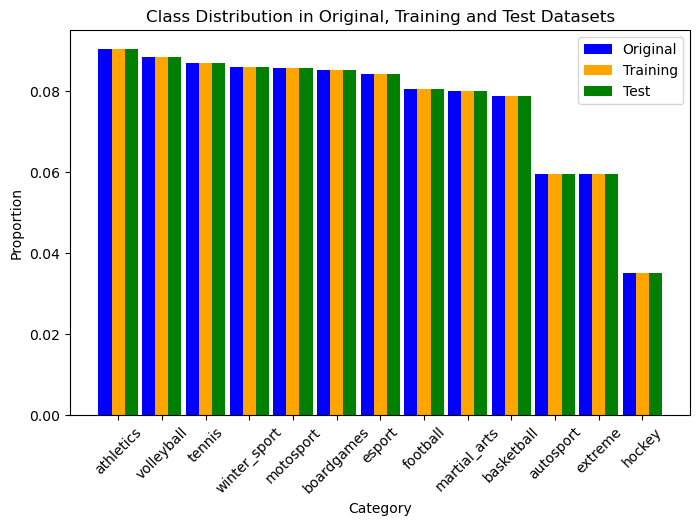

In [349]:
categories = original_distribution.index

fig, ax = plt.subplots(figsize=(8,5))
ax.bar(np.arange(len(categories)) - 0.3, original_distribution, width=0.3, color='blue', label='Original')
ax.bar(np.arange(len(categories)), train_distribution, width=0.3, color='orange', label='Training')
ax.bar(np.arange(len(categories)) + 0.3, test_distribution, width=0.3, color='green', label='Test')

ax.set_xlabel('Category')
ax.set_ylabel('Proportion')
ax.set_title('Class Distribution in Original, Training and Test Datasets')
ax.set_xticks(indices)
ax.set_xticklabels(categories, rotation=45)
ax.legend()

plt.show()

Как видно по графику, распределение категорий сохранено

**2.2. Так как сведения о категории представлены в категориальном формате, преобразую их в числовые с помощью Label Encoder**

In [351]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

**2.3 Векторизую тексты с помощью предобученной модели Word2Vec RusVectores - https://rusvectores.org/ru/models/**

In [353]:
model = KeyedVectors.load_word2vec_format('model_rnc.bin', binary=True)

In [355]:
print(list(model.key_to_index.keys())[:10])
print(len(model.key_to_index.keys()))

['xxxxxxxx_NUM', 'год_NOUN', 'xxxxxx_NUM', 'xxxxxxx_NUM', 'первый_ADJ', 'время_NOUN', 'человек_NOUN', 'introduction_PROPN', 'один_NUM', 'район_NOUN']
249333


In [ ]:
# print(model['спорт_NOUN'])

Поскольку в модели все слова идут с постфиксом, присоединенным через нижнее подчеркивание, добавляю к каждому слову часть речи через '_', а затем пропускаю через модель

In [ ]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'ADJ'
    elif treebank_tag.startswith('V'):
        return 'VERB'
    elif treebank_tag.startswith('N'):
        return 'NOUN'
    elif treebank_tag.startswith('R'):
        return 'ADV'
    else:
        return 'NOUN'  

def text2vec_with_postfixes(text):
    words = word_tokenize(text) 
    words_pos = pos_tag(words) 
    vecs = []
    for word, pos in words_pos:
        wordnet_pos = get_wordnet_pos(pos)  
        word_with_pos = f"{word}_{wordnet_pos}"  
        if word_with_pos in model:
            vecs.append(model[word_with_pos]) 
    if len(vecs) == 0:
        return np.zeros(model.vector_size)  
    text_vec = np.mean(vecs, axis=0)  
    return text_vec

tqdm.pandas()
X_train_vecs = np.stack(X_train.progress_apply(text2vec_with_postfixes))
X_test_vecs = np.stack(X_test.progress_apply(text2vec_with_postfixes))

In [358]:
def add_postfixes(text):
    words = word_tokenize(text)
    words_pos = pos_tag(words)
    words_with_postfixes = [f"{word}_{get_wordnet_pos(pos)}" for word, pos in words_pos]
    return words_with_postfixes

Ищу похожие слова, близкие к тем, которые встретились в случайно выбранном тексте

In [359]:
sample_text = df['cleaned_text'].sample().iloc[0]
print("Sample text:", sample_text)

words_with_postfixes = add_postfixes(sample_text)

for word in words_with_postfixes:
    if word in model:
        print(f"\nSimilar words for '{word}':")
        similar_words = model.most_similar(word, topn=5)
        for similar_word, similarity in similar_words:
            print(f"  {similar_word}: {similarity}")
    else:
        print(f"'{word}' not found in the model")
    print( )

Sample text: wss лоренцо балдассари покинуть мото гран ради схватка титул wortokenoid stokenoid достаточно интересный новость италия лоренцо балдассари победитель red btokenoid motogp rooktokenoid ctokenoid год самый известный итальянский пилот moto moto подписать контракт команда evan bros wortokenoid yamaha team год провести чемпионат wortokenoid stokenoid слух балда перейти wortokenoid состав официальный команда agtokenoid однако прийти официальный подтверждение новый дом стать итальянский evan bros wortokenoid yamaha team выступать yamaha yzf летний балдассари считать максимальный шанс стать чемпион wss год учитывать опыт младший категория мото гран moto год провести гонка выиграть гран подняться подиум год бороться титул начать сезон три победа четыре гонка возможность вступить evan bros появиться команда причина договориться вица чемпион год стивен одендааль
'wss_NOUN' not found in the model

'лоренцо_NOUN' not found in the model

'балдассари_NOUN' not found in the model


Simila

**2.4 Подбор гиперпараметров и применение LGBMClassifier**

Я использую LightGBMСlassifier, который используется для задач классификации и работает по принципу градиентного бустинга: он строит множество решающих деревьев и затем объединяет их результаты для получения более точных прогнозов. Он эффективен для больших данных

гиперпараметры:
- n_estimators - кол-во деревьев
- max_depth - максимальная глубина деревьев
- learning_rate - скорость обучения, определяющая шаги градиентного спуска
- colsample_bytree - доля признаков для каждого дерева

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

max_score = 0.5
best_params = {}

n_estimators_list = [100, 200, 500, 1000]
max_depth_list = [3, 4, 5, 6]
learning_rate_list = [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15]
colsample_bytree_list = [0.2, 0.5, 0.75, 1.0]

total_iterations = len(n_estimators_list) * len(max_depth_list) * len(learning_rate_list) * len(colsample_bytree_list)
progress_bar = tqdm(total=total_iterations, desc="Hyperparameter Tuning")

for n_estimators in n_estimators_list:
    for max_depth in max_depth_list:
        for learning_rate in learning_rate_list:
            for colsample_bytree in colsample_bytree_list:
                model = LGBMClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    learning_rate=learning_rate,
                    colsample_bytree=colsample_bytree,
                    n_jobs=-1,
                    verbose=-1
                )
                model.fit(X_train_vecs, y_train)
                preds = model.predict_proba(X_test_vecs)

                score = roc_auc_score(y_test, preds, multi_class='ovr')
                if score > max_score:
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'colsample_bytree': colsample_bytree
                    }
                    max_score = score

                    print(
                        f"New best score: {score} with params: "
                        f"n_estimators={n_estimators}, max_depth={max_depth}, "
                        f"learning_rate={learning_rate}, colsample_bytree={colsample_bytree}"
                    )

                progress_bar.update(1)
progress_bar.close()

print(f"Best parameters: {best_params}")
print(f"Best ROC AUC score: {max_score}")

New best score: 0.9565048978077267 with params: n_estimators=500, max_depth=6, learning_rate=0.1, colsample_bytree=0.2

In [360]:
best_params = {"n_estimators": 500,
    "max_depth": 6,
    "learning_rate": 0.1,
    "colsample_bytree": 0.2
    }

In [361]:
best_model = LGBMClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    colsample_bytree=best_params['colsample_bytree'],
    n_jobs=-1,
    verbose=-1
)
best_model.fit(X_train_vecs, y_train)

LGBMClassifier(colsample_bytree=0.2, max_depth=6, n_estimators=500, n_jobs=-1,
               verbose=-1)

In [362]:
best_preds = best_model.predict_proba(X_test_vecs)
final_score = roc_auc_score(y_test, best_preds, multi_class='ovr')
print(f"Final ROC AUC score: {final_score}")

Final ROC AUC score: 0.9552622989642434


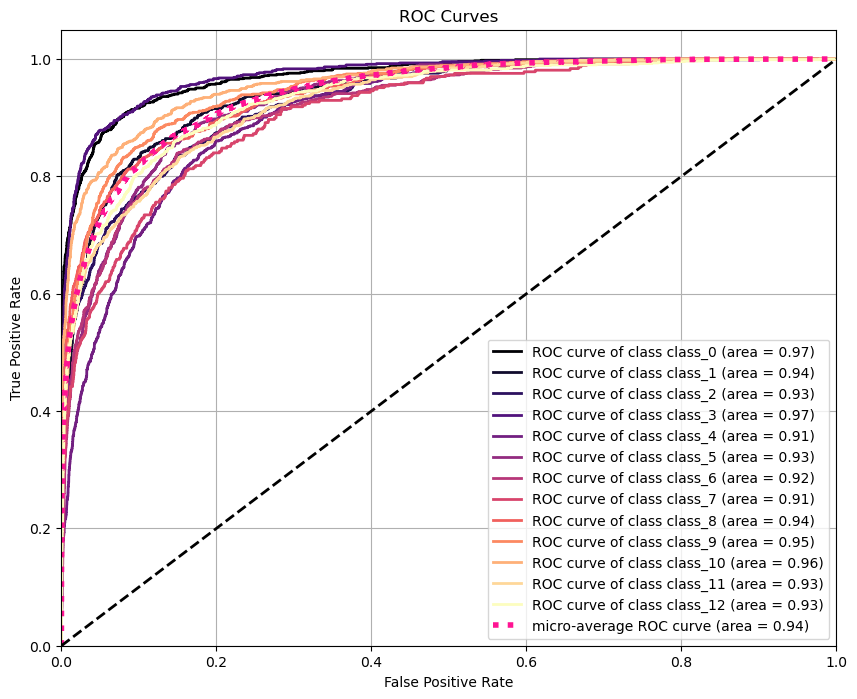

In [371]:
from matplotlib import cm

enc = {i: f'class_{i}' for i in range(len(df['category'].unique()))}

y_test_binarized = label_binarize(y_test, classes=range(len(enc)))
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10, 8))

colors = cm.get_cmap('magma', n_classes)

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'ROC curve of class {enc[i]} (area = {roc_auc[i]:0.2f})')

plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=4,
         label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc["micro"]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid()
plt.show()

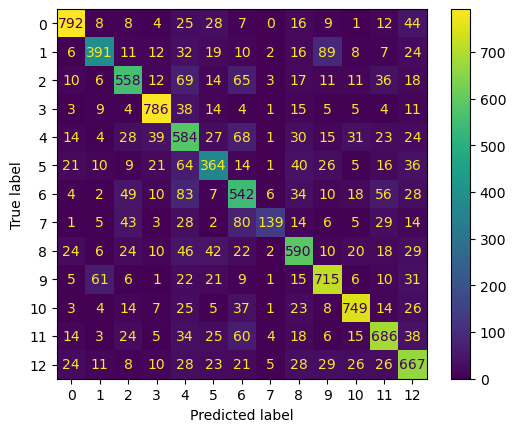

In [373]:
conf_matrix = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(conf_matrix, ).plot()

In [375]:
y_pred = best_model.predict(X_test_vecs)

precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
f1_micro = f1_score(y_test, y_pred, average='micro')

precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print("Микро-усреднение:")
print(f"Precision: {precision_micro:.4f}")
print(f"Recall: {recall_micro:.4f}")
print(f"F1-Score: {f1_micro:.4f}")

print("\nМакро-усреднение:")
print(f"Precision: {precision_macro:.4f}")
print(f"Recall: {recall_macro:.4f}")
print(f"F1-Score: {f1_macro:.4f}")

print("\nОтчет по классификации:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Микро-усреднение:
Precision: 0.7154
Recall: 0.7154
F1-Score: 0.7154

Макро-усреднение:
Precision: 0.7242
Recall: 0.6951
F1-Score: 0.7031

Отчет по классификации:
              precision    recall  f1-score   support

   athletics       0.88      0.84      0.86       954
   autosport       0.72      0.64      0.68       627
  basketball       0.68      0.65      0.67       830
  boardgames       0.84      0.86      0.85       899
      esport       0.51      0.66      0.57       888
     extreme       0.62      0.57      0.59       627
    football       0.59      0.67      0.63       849
      hockey       0.82      0.41      0.55       369
martial_arts       0.70      0.68      0.69       843
   motosport       0.80      0.76      0.78       903
      tennis       0.82      0.80      0.81       916
  volleyball       0.76      0.73      0.74       932
winter_sport       0.67      0.74      0.70       906

    accuracy                           0.72     10543
   macro avg       0.72   